In [20]:
import configparser
config = configparser.ConfigParser()
config.read('secrets.ini')
custom_vision_key = config['custom_vision']['key']
custom_vision_url = config['custom_vision']['url']
custom_vision_imgurl = config['custom_vision']['imgurl']

# print(custom_vision_key)
# print(custom_vision_url)

In [ ]:
import requests
import json
import base64

# data = open('anpr_samples\\mcl650.jpg', 'rb').read()

# dummy_res = requests.post(url='http://httpbin.org/post',
#                     data=data,
#                     headers={'Content-Type': 'application/octet-stream'})

# dummy_res_json = dummy_res.json()
# dummy_res_data_encoded = dummy_res_json['data'][len('data:application/octet-stream;base64,'):]
# dummy_res_data_decoded = base64.b64decode(dummy_res_data)

# assert dummy_res_data_decoded == data

In [21]:
dataheaders = {'Content-Type': 'application/octet-stream', 'Prediction-Key': custom_vision_key}
data = open('anpr_samples/hsv39.jpg', 'rb').read()

custom_vision_resp = requests.post(url=custom_vision_imgurl, data=data, headers=dataheaders).json()
print(custom_vision_resp)

{'id': '1fa4e1dd-adce-4671-a5f2-2b1edf49929e', 'project': '2c4e0486-88ee-4369-b033-dd24e1e07885', 'iteration': 'e48ad707-5e08-47dd-9273-396ce4a4afa7', 'created': '2020-06-01T08:19:36.856Z', 'predictions': [{'probability': 0.0160742067, 'tagId': '1752966c-d1e1-46f5-924b-505d90a16981', 'tagName': 'plate', 'boundingBox': {'left': 0.004565847, 'top': 0.240038842, 'width': 0.0257141441, 'height': 0.0753260553}}, {'probability': 0.115149885, 'tagId': '1752966c-d1e1-46f5-924b-505d90a16981', 'tagName': 'plate', 'boundingBox': {'left': 0.00208997354, 'top': 0.278702438, 'width': 0.0318060964, 'height': 0.116016328}}, {'probability': 0.0116057871, 'tagId': '1752966c-d1e1-46f5-924b-505d90a16981', 'tagName': 'plate', 'boundingBox': {'left': 0.56674093, 'top': 0.323081523, 'width': 0.07001418, 'height': 0.0435321629}}, {'probability': 0.2426998, 'tagId': '1752966c-d1e1-46f5-924b-505d90a16981', 'tagName': 'plate', 'boundingBox': {'left': 0.8473767, 'top': 0.2650637, 'width': 0.04177034, 'height': 0.

In [ ]:
dataheaders = dataheaders = {'Content-Type': 'application/json', 'Prediction-Key': custom_vision_key}
data = {'url': 'http://www.rollingstock.net.au/wp-content/uploads/12628349_1669663946618401_3099267999011849495_o.jpg'}
custom_vision_resp = requests.post(url=custom_vision_url, data=json.dumps(data), headers=dataheaders).json()

print(type(custom_vision_resp))

In [ ]:
import pandas as pd

pd.DataFrame(custom_vision_resp['predictions']).sort_values(by='probability',ascending=False).head(1).to_dict()

##  common objects detection 

In [11]:
import os
import sys
import requests
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
from io import BytesIO

import configparser
config = configparser.ConfigParser()
config.read('secrets.ini')
custom_vision_key = config['custom_vision']['key']
custom_vision_url = config['custom_vision']['url']

subscription_key = config['computer_vision']['key']
endpoint = config['computer_vision']['url']
text_recognition_url = endpoint + "vision/v2.1/read/core/asyncBatchAnalyze"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://upload.wikimedia.org/wikipedia/commons/d/dd/Cursive_Writing_on_Notebook_paper.jpg"
#image_file = open('anpr_samples/Cursive_Writing_on_Notebook_paper.jpg', 'rb').read()
image_file = open('anpr_samples/hsv39.jpg', 'rb').read()
headers = {'Ocp-Apim-Subscription-Key': subscription_key}
# data = {'url': image_url}
# response = requests.post(
#     text_recognition_url, headers=headers, json=data)
# response.raise_for_status()
response = requests.post(
    url=text_recognition_url, 
    data=image_file, 
    headers={'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'})


In [12]:
response.raise_for_status()

# Extracting text requires two API calls: One call to submit the
# image for processing, the other to retrieve the text found in the image.

# Holds the URI used to retrieve the recognized text.
operation_url = response.headers["Operation-Location"]


In [13]:
# The recognized text isn't immediately available, so poll to wait for completion.
analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers={'Ocp-Apim-Subscription-Key': subscription_key})
    analysis = response_final.json()
    print(analysis)
    time.sleep(1)
    if ("recognitionResults" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'Failed'):
        poll = False



{'status': 'Succeeded', 'recognitionResults': [{'page': 1, 'clockwiseOrientation': 359.45, 'width': 1280, 'height': 781, 'unit': 'pixel', 'lines': [{'boundingBox': [817, 554, 921, 553, 921, 580, 818, 581], 'text': 'HSV39', 'words': [{'boundingBox': [836, 555, 920, 553, 920, 580, 835, 581], 'text': 'HSV39'}]}]}]}


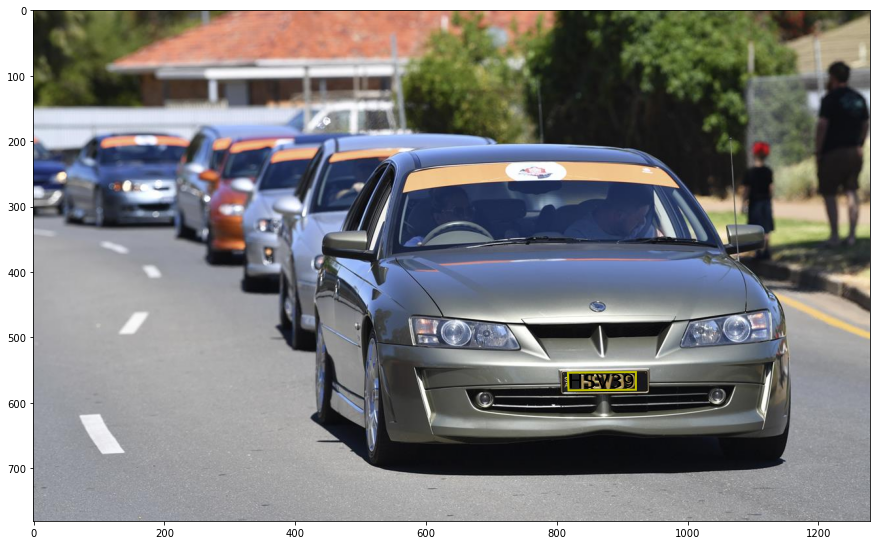

In [17]:
polygons = []
if ("recognitionResults" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [(line["boundingBox"], line["text"])
                for line in analysis["recognitionResults"][0]["lines"]]
image = Image.open(BytesIO(image_file))

# Display the image and overlay it with the extracted text.
plt.figure(figsize=(15, 15))

ax = plt.imshow(image)
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1])
                for i in range(0, len(polygon[0]), 2)]
    text = polygon[1]
    patch = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")

plt.show()